# Exploration 8
# Compensate for the defect in Portrait mode

## |프로젝트: 인물 모드 문제점 찾기
### |프로젝트 학습 과정

1. 인물모드 직접 해 보기
2. 사진에서 문제점 찾기
3. 해결 방법을 제안해 보기
  - 세그멘테이션의 한계
  - 피사계 심도 이해하기
  - 3D Depth Camera 활용하기
  - 깊이 영상(Depth image) 활용하기
  - IR(적외선)을 활용한 사례

### |프로젝트 평가
| |평가문항|상세기준|
|------|---|---|
|1|인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2|제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3|인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

### |프로젝트 전체 개요 다시 정리

1. 인물모드 사진 아웃포커싱 효과 적용되게 하기
    - 사람, 고양이 사진, 크로마키사진 1장 이상 제작
2. 제작한 인물모드 사진에서 문제점 찾기
    - 문제점 지적, 원인 찾기
3. 솔루션 찾기
    - 문제점 개선할 수 있는 솔루션 찾기
    - 추가 depth 정보 활용
    - semantic segmantation mask의 오류 보완할 수 있는 솔루션 제시

## Import Libraries

In [2]:
import cv2
import os, glob
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import urllib
from PIL import Image

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from PIL import Image

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess(): 전처리 함수   
  - 이미지를 적절한 크기로 resize   
  - Chanege: OpenCV default BGR → RGB   
  - 이미지를 input tenser로 변형하여 return  

run(): 세그멘테이션 함수
  - 전처리 된 이미지 run() 함수에서 입력값으로 사용

In [4]:
# deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight 다운로드
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


**pretrained weight**은 구글이 제공   
DeepLabModel은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [5]:
# 선택 이미지 1
img_path1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'
img_orig = cv2.imread(img_path1) 
print (img_orig.shape)

(1440, 1080, 3)


(1440, 1080, 3) (513, 384, 3) 15


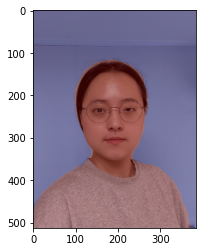

In [6]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# seg_map.max() 의 의미는 물체로 인식된 라벨 중 가장 큰 값을 뜻하며, label의 수와 일치

# PASCAL VOC로 학습된 label
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird',
               'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
len(LABEL_NAMES)

# 사람을 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
# 예측 중 사람만 추출 person의 label은 15
img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

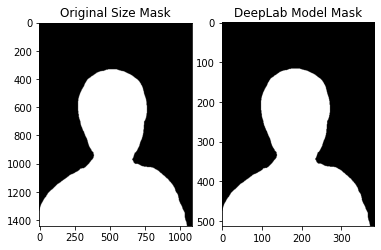

In [7]:
# (4) 세그멘테이션 결과를 원래 크기로 복원하기
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

x, y 좌표가 다른 점을 주목해서 봐주세요!

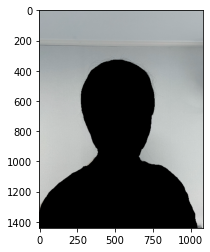

In [8]:
# (5) 배경 흐리게 하기
# 배경 이미지 얻기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

bitwise_not : not 연산하여 이미지 반전

bitwise_and : 배경과 and 연산하여 배경만 있는 이미지를 얻을 수 있다.

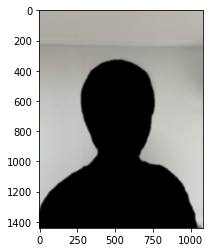

In [9]:
# 배경 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

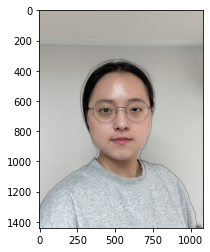

In [10]:
# (6) 흐린 배경과 원본 영상 합성
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

첫 번째 이미지는 배경이 없는 이미지였으니까, 배경이 더 복잡한 두 번째 이미지로 시도해보겠습니다! 😁

In [11]:
# 선택 이미지 2
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'
img_orig = cv2.imread(img_path2) 
print (img_orig.shape)

(1440, 1080, 3)


(1440, 1080, 3) (513, 384, 3) 15


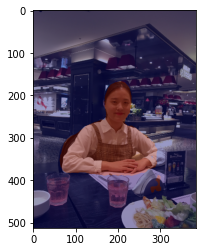

In [12]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# 사람을 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
# 예측 중 사람만 추출 person의 label은 15
img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

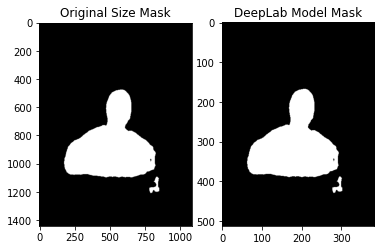

In [13]:
# (4) 세그멘테이션 결과를 원래 크기로 복원하기
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

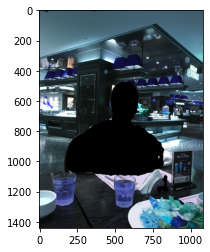

In [14]:
# (5) 배경 흐리게 하기
# 배경 이미지 얻기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

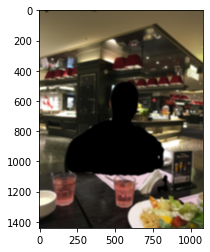

In [15]:
# 배경 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

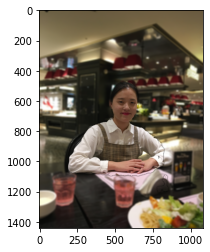

In [16]:
# (6) 흐린 배경과 원본 영상 합성
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

두 번째 사진은 배경이 상당히 복잡한 사진이었습니다. 저를 잘 찾아내긴 했지만 문제가 있긴 있습니다. 테이블 위에 올려져 있는 냅킨까지😅 같이 인식을 해버렸네요!

### 세 번째 이미지로는 크로마키 배경 합성

In [17]:
# 선택 이미지 3
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/rabong.png'
img_orig = cv2.imread(img_path3) 
print (img_orig.shape)

(1329, 1440, 3)


(1329, 1440, 3) (473, 513, 3) 8


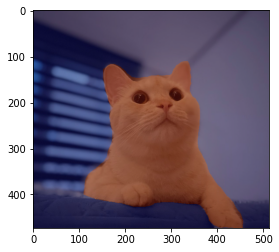

In [18]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# 고양이를 찾아 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
# 예측 중 사람만 추출 cat의 label은 8
img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

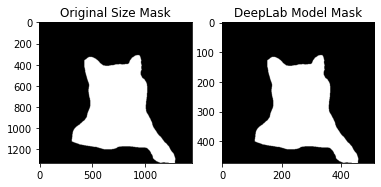

In [19]:
# (4) 세그멘테이션 결과를 원래 크기로 복원하기
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

(1440, 1329, 3)


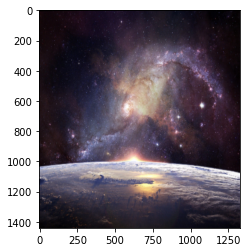

In [20]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'
img_bg = cv2.imread(img_path4)
img_bg = MODEL.preprocess(img_bg)
img_bg = cv2.resize(img_bg,img_mask_up.shape)
print(img_bg.shape)
plt.imshow(img_bg)

In [21]:
target_size = (img_orig.shape[1], img_orig.shape[0])
print("변경하려는 사이즈: ", target_size)
bg_resize = cv2.resize(img_bg, target_size)
print("배경 변경한 사이즈: ", bg_resize.shape)

변경하려는 사이즈:  (1440, 1329)
배경 변경한 사이즈:  (1329, 1440, 3)


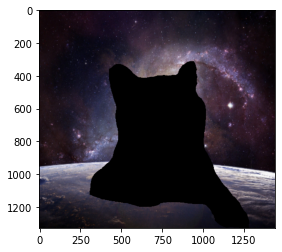

In [22]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_masked = cv2.bitwise_and(bg_resize, img_bg_mask)
plt.imshow(img_bg_masked)
plt.show()

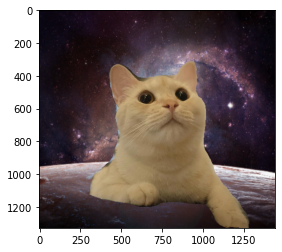

In [23]:
# (6) 흐린 배경과 원본 영상 합성
# 255인 부분만 원본을 가져온 후 나머지는 blur 이미지
img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

🥕 주의점

1. cat을 할 땐 cat의 라벨 값을 지정해줘야 합니다. label 값을 변경 안 하고 시도하면 저처럼 순간 당황할 수 있습니다.😂
2. 원본 이미지와 배경을 합성해줄 때, 두 이미지의 사이즈가 같아야 합니다. 이미지 사이즈가 다르면 오류가 뜹니다.

🥕 아쉬운 점

1. 계속 코드가 반복되다 보니 조금 어지러운 것 같아서 이를 함수로 묶어보는 작업을 하겠습니다.

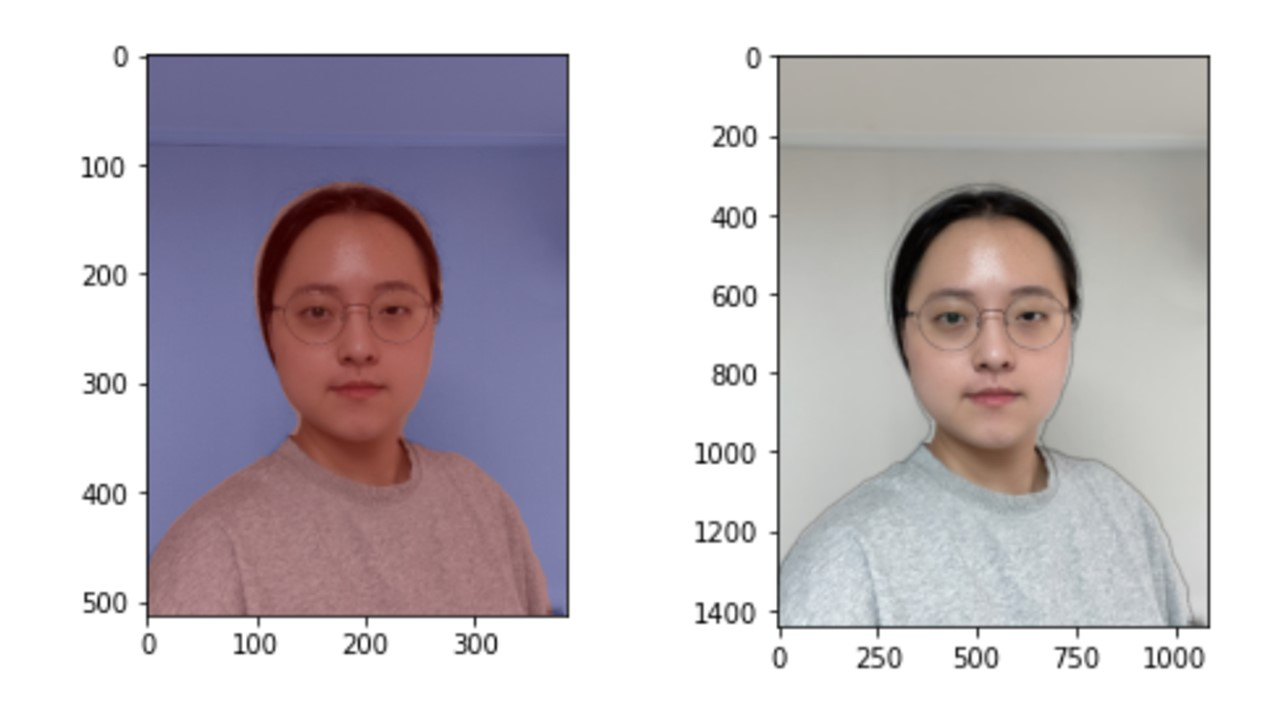

In [24]:
img1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/exam(1).JPG'
Image.open(img1, mode = 'r')

#### 선택 이미지 1
2. 위 이미지는 인물보다 경계를 더 크게 잡아, 다시 합성했을 때 검은색 선의 빈 공간이 생깁니다.

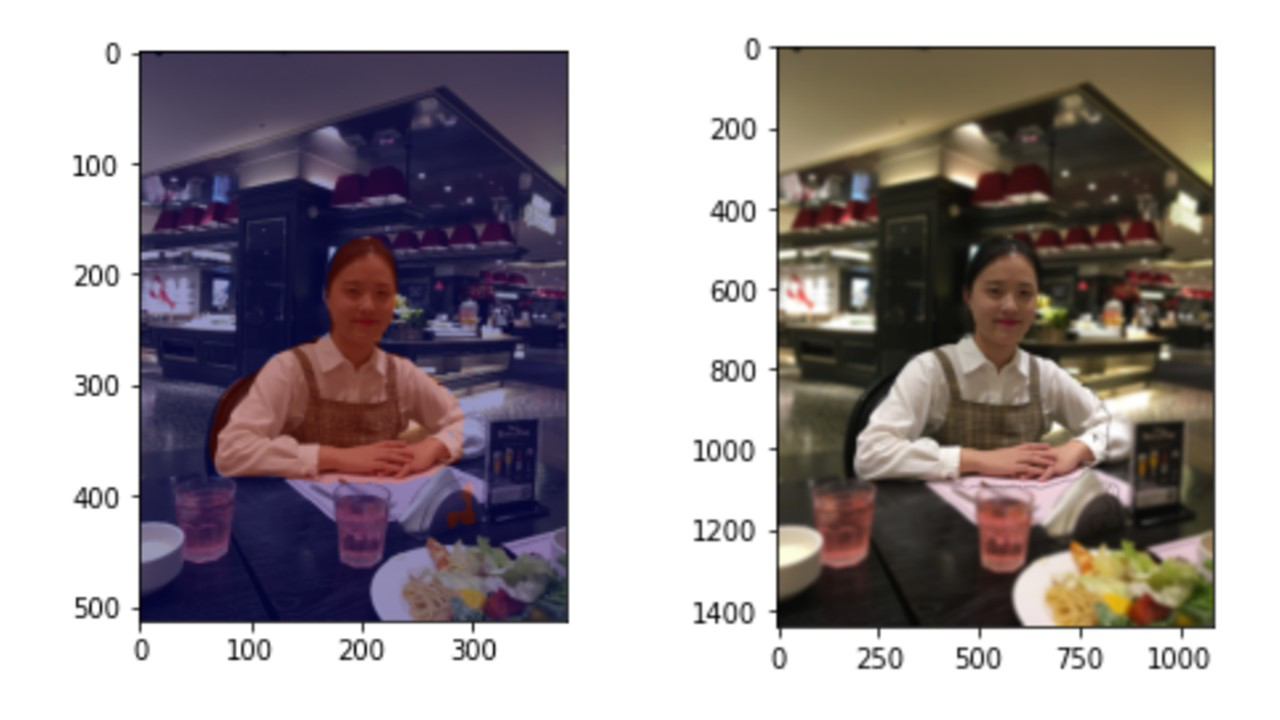

In [25]:
img2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/exam(2).JPG'
Image.open(img2, mode = 'r')

#### 선택 이미지 2
3. 위 이미지는 인물보다 경계를 더 크게 잡는 공통적 문제점이 발견됩니다. 냅킨이나 뒤의 의자 등 사물까지 잡는 문제점이 있습니다.

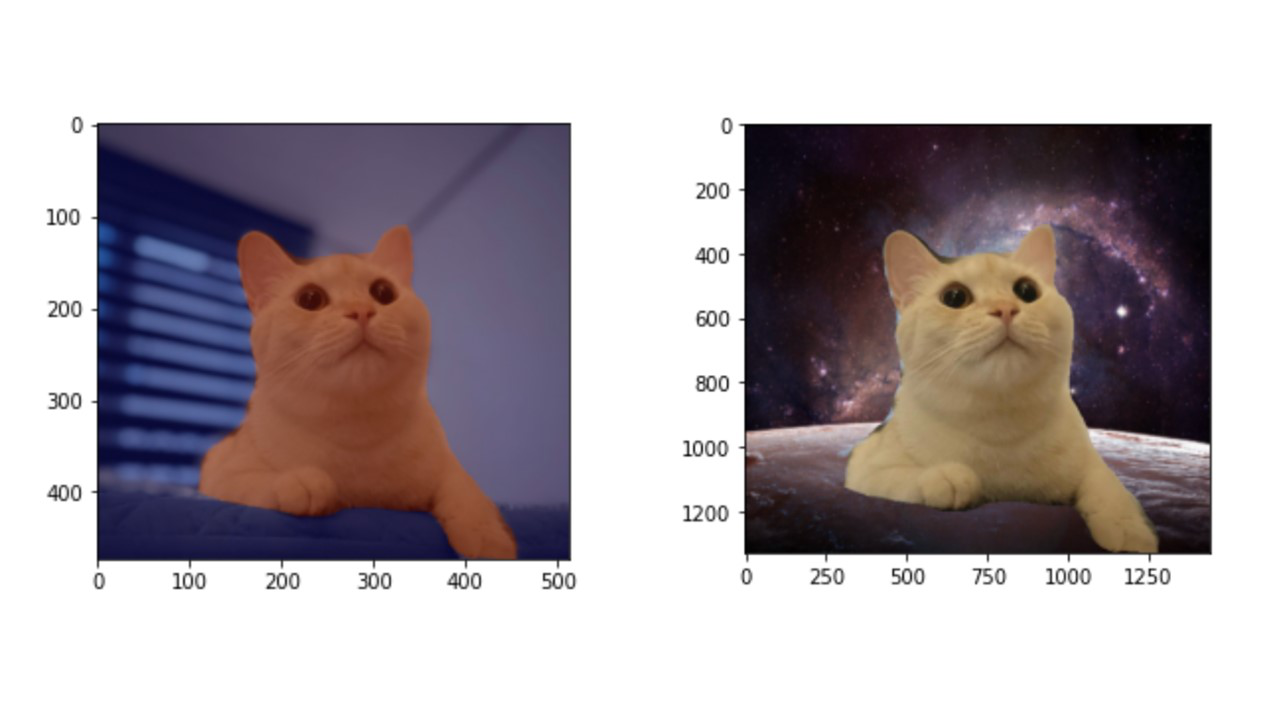

In [26]:
img3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/exam(3).JPG'
Image.open(img3, mode = 'r')

#### 선택 이미지 3
4. 위 이미지도 객체보다 경계를 더 크게 잡아, 다시 합성했을 때 검은색 선의 빈 공간이 생깁니다.

### 세그멘테이션 함수 만들기

In [27]:
# PASCAL VOC의 라벨
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
               'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
               'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']

# 이미지 경로
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'

def seg_img(img_name, label):
    img_path = os.path.join(img_dir, img_name)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    # 마스크 만들기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')
    plt.show()
    
    # 배경 흐리게 만들기
    img_orig_blur = cv2.blur(img_orig, (13,13))
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 마스크를 이용해서 배경만 추출    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 배경과 합치기
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(434, 726, 3) (306, 513, 3) 15


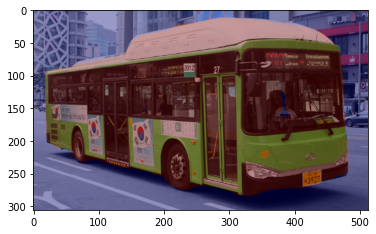

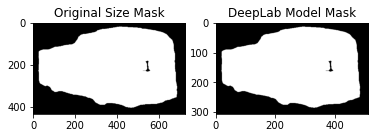

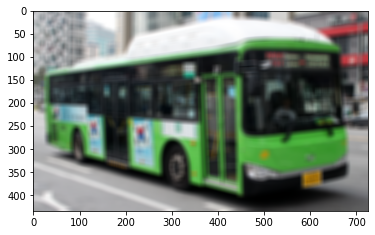

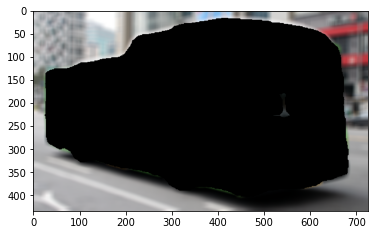

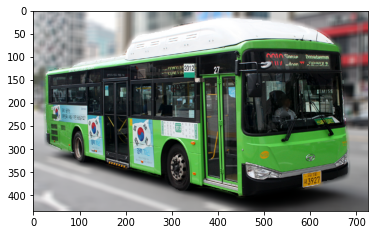

In [28]:
seg_img('bus.png', 'bus')

(337, 600, 3) (288, 513, 3) 6


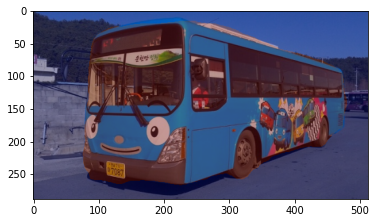

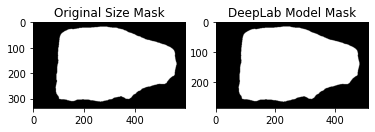

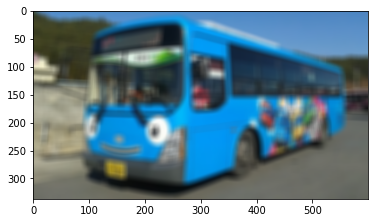

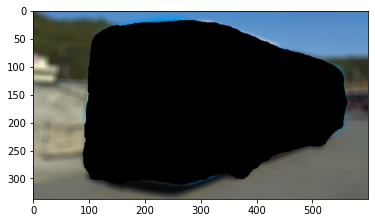

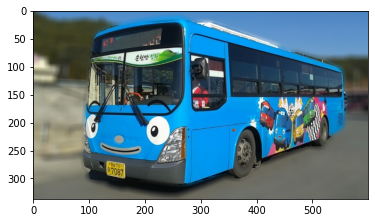

In [29]:
seg_img('tayo.jpg', 'bus')

### 배경 합성하기

In [30]:
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'

def bg_concat(img_name, label, bg_name):
    img_path = os.path.join(img_dir, img_name)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    # 마스크 만들기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')
    plt.show()
    
    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir, bg_name)
    img_bg = cv2.imread(bg_path)
    
    img_bg = MODEL.preprocess(img_bg)
    img_bg = cv2.resize(img_bg,img_mask_up.shape)
    print(img_bg.shape)
    plt.imshow(img_bg)
    
    target_size = (img_orig.shape[1], img_orig.shape[0])
    print("변경하려는 사이즈: ", target_size)
    bg_resize = cv2.resize(img_bg, target_size)
    print("배경 변경한 사이즈: ", bg_resize.shape)
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_masked = cv2.bitwise_and(bg_resize, img_bg_mask)
    plt.imshow(img_bg_masked)
    plt.show()
    
    img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

(337, 600, 3) (288, 513, 3) 6


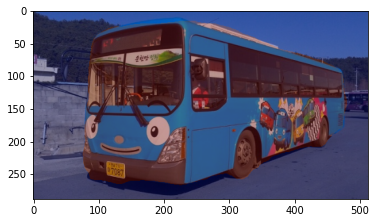

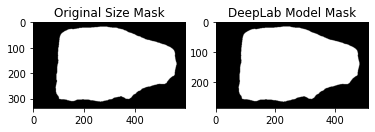

(600, 337, 3)
변경하려는 사이즈:  (600, 337)
배경 변경한 사이즈:  (337, 600, 3)


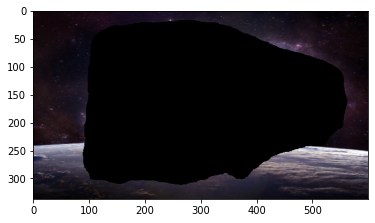

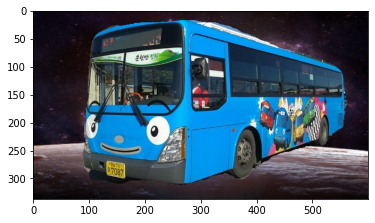

In [31]:
bg_concat('tayo.jpg','bus','background.jpg')

### 3D Depth Camera

#### Python과 OpenCV – 46 : 스트레오 이미지로부터 깊이 맵(Depth Map) 생성하기

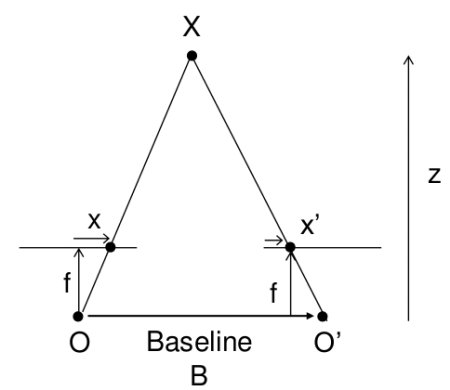

동일한 이미지 2개가 있다면, 이를 이용해 깊이에 대한 정보를 얻을 수 있다.   
tsukuba_l, tsukuba_r 이미지는 각각 동일한 장면에 대해 왼쪽과 오른쪽 방향에서 촬영한 이미지이다.

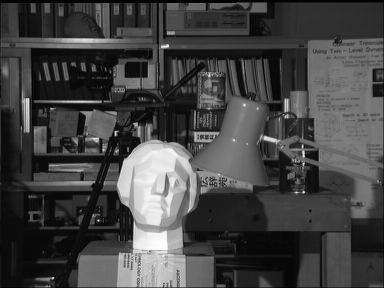

In [32]:
# 왼쪽 방향에서 촬영한 사진
img_3d = os.getenv('HOME')+'/aiffel/human_segmentation/images/tsukuba_l.png'
Image.open(img_3d, mode = 'r')

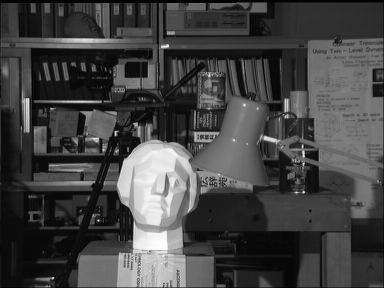

In [33]:
# 오른쪽 방향에서 촬영한 사진
img_3d2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/tsukuba_r.png'
Image.open(img_3d, mode = 'r')

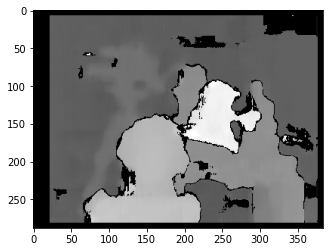

In [42]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'
img_path1 = os.path.join(img_dir, 'tsukuba_l.png')
img_path2 = os.path.join(img_dir, 'tsukuba_r.png')
imgL = cv2.imread(img_path1,0)
imgR = cv2.imread(img_path2,0)
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

실행 결과는 위와 같다.

- 카메라로부터 가까운 픽셀은 밝고, 멀어질 수록 어둡다.
- 결과 이미지에 잘못된 잡음 등은 numDisparities와 blockSize 값을 조정해 개선할 수 있다.

### 솔루션

- 프로젝트 가이드 라인에 있는 세그멘테이션의 한계, 피사계 심도 이해하기, 3D Depth Camera 활용하기, 깊이 영상(Depth image) 활용하기, IR(적외선)을 활용한 사례 등은 찾아보았지만 어떤 것을 어디까지 봐야할 지 감이 잘 오지 않았다.

1. 마스크를 블러 처리하는 과정에서 나타나는 경계를 블러처리 해주어서 더 부드럽게 만들어주기
2. 객체를 인식할 때, depth 기능을 사용하면 인식해야 할 객체와 배경 등을 구분할 수 있을 것 같음

   
더 보완해야 할 점
- 이미지 검출(detection)과 분할(segmentation)의 주요 테크닉에 대해 다시 공부하기
- PASCAL VOC Challenge 등을 찾아 보면 더 도움이 되지 않을까 싶음
[파스칼 챌린지](http://host.robots.ox.ac.uk/pascal/VOC/)

그 외, 자료
- R-CNN, Fast R-CNN, Faster R-CNN 살펴보기
[R-CNN](https://arxiv.org/abs/1311.2524)
[Fast R-CNN](https://arxiv.org/abs/1504.08083)
[Faster R-CNN](https://arxiv.org/abs/1506.01497)
[Mask R-CNN](https://arxiv.org/abs/1703.06870)
- Depth Map 을 활용한 합성
https://www.i-art3d.com/Eng/About_Depth.htm